<a href="https://colab.research.google.com/github/MisaelManingo/ChemVATS/blob/main/THESIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **`ChemVATS`: Chemical Variational Autoencoder using Transformers for SELFIES**
formerly *Encoding and Decoding Molecules using Transformers*

Misael Andre D. Maningo | Dr. Miguel Francisco M Remolona

## A. Imports
Imports and installs to Google Colab.

In [1]:
!pip install selfies
import selfies as sf

In [2]:
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import Image, display

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 50.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dropout, GlobalAveragePooling1D, Layer, Lambda, Add
from tensorflow.keras.models import Model, Sequential
from keras import backend as K
from collections import Counter

import random
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

In [4]:
!pip install keras-nlp --upgrade
from keras_nlp.layers import TransformerEncoder, TransformerDecoder, SinePositionEncoding

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.1/590.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 59.0 MB/s eta 0:00:00
Using TensorFlow backend


Output wrapping in Google Colab.

In [5]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

## B. Database

### B.1. Sample ZINC Database (250k)

In [6]:
data_url = "https://github.com/aspuru-guzik-group/selfies/raw/16a489afa70882428bc194b2b24a2d33573f1651/examples/vae_example/datasets/dataJ_250k_rndm_zinc_drugs_clean.txt"
data_SMILES = pd.read_csv(data_url)
print("Total number of molecules in imported dataset:", len(data_SMILES))

Total number of molecules in imported dataset: 249455


Convert from SMILES to SELFIES.

In [7]:
LOAD_FROM_FILE = True
MASTER_SELFIES_FILE_NAME = '/content/drive/MyDrive/Colab Notebooks/Models/master_SELFIES.txt'

master_SELFIES = []

if not LOAD_FROM_FILE:
    master_SELFIES = [sf.encoder(s) for s in data_SMILES.iloc[0:len(data_SMILES)-1, 0]]
    with open(MASTER_SELFIES_FILE_NAME, 'w') as file:
        for item in master_SELFIES:
            file.write(f"{item}\n")
else:
    with open(MASTER_SELFIES_FILE_NAME, 'r') as file:
        for line in file:
            master_SELFIES.append(line.strip())

max_length = max(sf.len_selfies(s) for s in master_SELFIES)

### B.2. ZINC API

In [ ]:
import requests
import os

In [ ]:
zinc_api_url = "https://zinc.docking.org/substances.json"

params = {
    "property_names": "smiles",
    "count": 1000,  # Number of compounds to retrieve
    "order_by": "popularity",
    "output_format": "json",
}

In [ ]:
response = requests.get(zinc_api_url, params=params)
data = response.json()

if response.status_code == 200:
    data_SMILES = [compound["smiles"] for compound in data]
else:
    print("Failed to retrieve data from ZINC.")
    data_SMILES = []

In [ ]:
output_file = "/content/drive/MyDrive/Colab Notebooks/Models/ZINCRequest_SMILES.txt"

with open(output_file, "w") as file:
    for smiles in data_SMILES:
        file.write(smiles + "\n")

print(f"SMILES strings saved to {output_file}")

SMILES strings saved to /content/drive/MyDrive/Colab Notebooks/Models/ZINCRequest_SMILES.txt


## C. Data Preprocessing

### C.1. SELFIES Encoding

Lists all unique symbols from master data set and makes a look-up table.

In [8]:
alphabet = sf.get_alphabet_from_selfies(master_SELFIES)
alphabet = list(sorted(alphabet))  # ['[=O]', '[C]', '[F]', '[O]', '[nop]']
alphabet.insert(0, "[nop]") # [nop] is a special padding symbol. Placed at position 0
vocab_size = len(alphabet)

symbol_to_idx = {s: i for i, s in enumerate(alphabet)}
idx_to_symbol = {v: k for k, v in symbol_to_idx.items()}

Converts from SELFIES to integer (label) encoding.

In [9]:
LOAD_FROM_FILE = True
MASTER_SET_FILE_NAME = '/content/drive/MyDrive/Colab Notebooks/Models/master_set.npy'

if not LOAD_FROM_FILE:
    master_set = []
    for x in range(len(master_SELFIES)):
        master_set.append(sf.selfies_to_encoding(
            selfies = master_SELFIES[x],
            vocab_stoi = symbol_to_idx,
            pad_to_len = max_length,
            enc_type = "label"
        ))
    master_set = np.array(master_set)
    if vocab_size > 126: print("WARNING: Use of int8 might not represent all integers.")
    np.save(MASTER_SET_FILE_NAME, master_set.astype(np.int8)) # int8 only stores integers from -127 to 127 ONLY!!!
else:
    master_set = np.load(MASTER_SET_FILE_NAME)

### Checking occurences for each token in the master set.

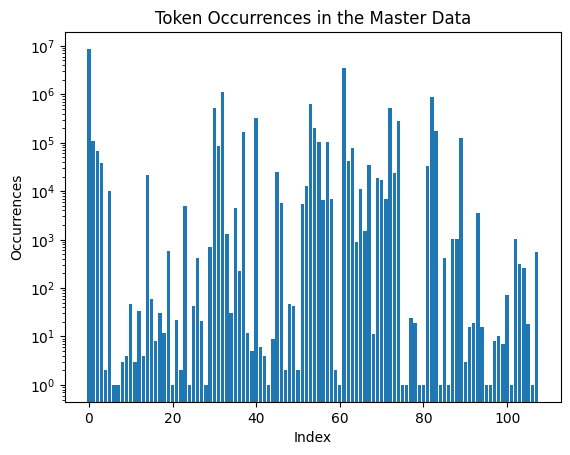

{'[nop]': 8622723, '[C]': 3533614, '[=C]': 1124749, '[Ring1]': 858760, '[Branch1]': 621078, '[=Branch1]': 523626, '[N]': 508932, '[=O]': 318166, '[O]': 279513, '[Branch2]': 202231, '[Ring2]': 177924, '[=N]': 169068, '[S]': 126691, '[#Branch1]': 110664, '[C@@H1]': 104643, '[C@H1]': 101674, '[=Branch2]': 85254, '[F]': 79420, '[#Branch2]': 66408, '[Cl]': 42797, '[#C]': 38534, '[NH1+1]': 35134, '[P]': 32584, '[=Ring1]': 25308, '[O-1]': 23915, '[/C]': 21745, '[NH1]': 18937, '[NH2+1]': 17342, '[Br]': 12715, '[N+1]': 10818, '[#N]': 10270, '[C@]': 7033, '[NH3+1]': 6788, '[C@@]': 6566, '[=Ring2]': 5738, '[=S]': 5554, '[/N]': 4849, '[=NH1+1]': 4577, '[\\C]': 3480, '[N-1]': 1475, '[=N+1]': 1279, '[\\N]': 1048, '[S@]': 1036, '[S@@]': 1008, '[I]': 887, '[/S]': 692, '[/NH1+1]': 572, '[\\S]': 555, '[/O]': 407, '[S-1]': 407, '[\\O-1]': 318, '[\\O]': 261, '[=NH2+1]': 226, '[\\NH1]': 72, '[/Cl]': 59, '[=S@@]': 47, '[/C@@H1]': 46, '[=S@]': 43, '[/O-1]': 42, '[/C@H1]': 34, '[/N+1]': 31, '[=N-1]': 30, '[P@

In [17]:
#@title {vertical-output: true}
token_counts = Counter(master_set.flatten())
numbers = list(token_counts.keys())
occurrences = list(token_counts.values())

plt.bar(numbers, occurrences, align='center')
plt.xlabel('Index')
plt.ylabel('Occurrences')
plt.yscale('log')
plt.title('Token Occurrences in the Master Data')
plt.show()

token_counts = {idx_to_symbol[key]: value for key, value in token_counts.items()}
token_counts = {k: v for k, v in sorted(token_counts.items(), key=lambda item: item[1], reverse=True)}
print(token_counts)

### Length Visualization

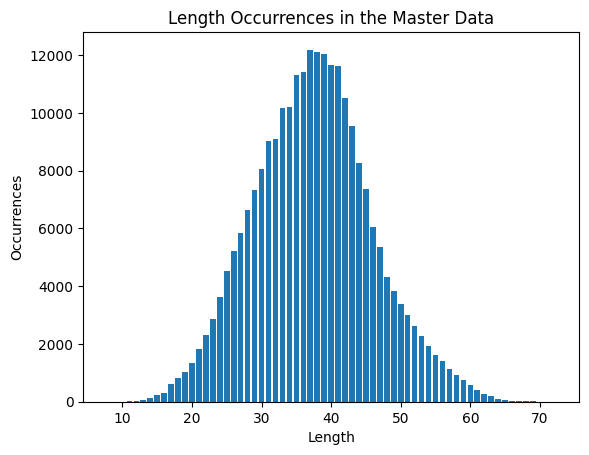

Sort based on length (ascending): {8: 3, 9: 3, 10: 5, 11: 16, 12: 20, 13: 61, 14: 118, 15: 233, 16: 308, 17: 612, 18: 824, 19: 1030, 20: 1330, 21: 1833, 22: 2316, 23: 2848, 24: 3641, 25: 4516, 26: 5213, 27: 5844, 28: 6641, 29: 7312, 30: 8071, 31: 9023, 32: 9097, 33: 10154, 34: 10197, 35: 11323, 36: 11412, 37: 12183, 38: 12115, 39: 12027, 40: 11639, 41: 11606, 42: 10495, 43: 9548, 44: 8252, 45: 7348, 46: 6054, 47: 5350, 48: 4324, 49: 3817, 50: 3393, 51: 2985, 52: 2606, 53: 2274, 54: 1934, 55: 1602, 56: 1415, 57: 1129, 58: 924, 59: 743, 60: 570, 61: 412, 62: 258, 63: 197, 64: 102, 65: 72, 66: 38, 67: 16, 68: 8, 69: 8, 70: 4, 72: 2}
Sort based on size (descending): {37: 12183, 38: 12115, 39: 12027, 40: 11639, 41: 11606, 36: 11412, 35: 11323, 42: 10495, 34: 10197, 33: 10154, 43: 9548, 32: 9097, 31: 9023, 44: 8252, 30: 8071, 45: 7348, 29: 7312, 28: 6641, 46: 6054, 27: 5844, 47: 5350, 26: 5213, 25: 4516, 48: 4324, 49: 3817, 24: 3641, 50: 3393, 51: 2985, 23: 2848, 52: 2606, 22: 2316, 53: 2274

In [21]:
#@title {vertical-output: true}
length_counts = Counter([len(token)-(token == 0).sum() for token in master_set])
numbers = list(length_counts.keys())
occurrences = list(length_counts.values())

plt.bar(numbers, occurrences, align='center')
plt.xlabel('Length')
plt.ylabel('Occurrences')
plt.title('Length Occurrences in the Master Data')
plt.show()
length_counts = dict(sorted(length_counts.items()))
print("Sort based on length (ascending):", length_counts)
length_counts = dict(sorted(length_counts.items(), key=lambda item: item[1], reverse=True))
print("Sort based on size (descending):", length_counts)

### C.2. Data Splitting
Splits data into training/validation/test sets. Also determines length of padding needed.

In [26]:
TRAIN_SIZE = 80_000
VALIDATION_SIZE = 10_000
TEST_SIZE = 50_000

train_set = master_set[0:TRAIN_SIZE]
validation_set = master_set[TRAIN_SIZE:TRAIN_SIZE+VALIDATION_SIZE]
test_set = master_set[TRAIN_SIZE+VALIDATION_SIZE:TRAIN_SIZE+VALIDATION_SIZE+TEST_SIZE]

## C. Custom Class and Methods

In [22]:
def sampling(args):
    """Sampling from latent distribution."""
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], max_length, latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_var) * epsilon

## E. Building

### E.1. Model

In [23]:
#@title {vertical-output: true}
embed_dim = 64  # Embedding size for each token
num_heads = 6  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
latent_dim = 8 # Dimensions of latent reperesentation
beta = 1


encoder_input = Input((max_length,), dtype='int32', name='EncoderInput')
embedding = Embedding(
    input_dim=vocab_size,
    output_dim=embed_dim,
    input_length=max_length,
    trainable=True,
    mask_zero=True,
    name='TokenEmbedding')(encoder_input)
positional_encoding = SinePositionEncoding(name='PositionEmbedding')(embedding)
x = Add(name='EmbAddPos')([embedding, positional_encoding])
x = TransformerEncoder(
    intermediate_dim=ff_dim,
    num_heads=num_heads,
    dropout=0,
    name='TransformerEncoder')(x)
# x = Dense(64, activation='relu', name='TransformerDense')(x) # "Transformer" Dense
z_mean = Dense(latent_dim, name='DenseMean')(x)
z_log_var = Dense(latent_dim, name='DenseLogVar')(x)
z = Lambda(sampling, name='LatentDense')([z_mean, z_log_var])
encoder = Model(encoder_input, [z_mean, z_log_var, z], name="ChemVATSEncoder")

decoder_input = Input((max_length,latent_dim,), name='DecoderInput')
output = Dense(50, activation='relu', name='DecoderDense')(decoder_input)
output = Dense(vocab_size, activation='softmax', name='FinalDense')(output)
decoder = Model(decoder_input, output, name="Decoder")

vae_output = decoder(encoder(encoder_input)[2])
vae = Model(encoder_input, vae_output, name="ChemVATS")

reconstruction_loss = keras.losses.sparse_categorical_crossentropy(encoder_input, vae_output)
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + beta * kl_loss)
vae.add_loss(vae_loss)

vae.compile(
    optimizer = 'adam',
    # loss = my_loss_fn,
    metrics=['sparse_categorical_accuracy'],
)

vae.summary(
    expand_nested=True,
    layer_range=["Encoder", "Decoder"]
)

Model: "ChemVATS"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 EncoderInput (InputLayer)   [(None, 72)]                 0         []                            
                                                                                                  
 ChemVATSEncoder (Functiona  [(None, 72, 8),              28004     ['EncoderInput[0][0]']        
 l)                           (None, 72, 8),                                                      
                              (None, 72, 8)]                                                      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| EncoderInput (InputLayer)  [(None, 72)]                 0         []                           |
|                                                                                          

VAE Loss is defined as follows

$\text{Total Loss} = \mathcal{L}(x,\hat{x}) + \beta \times \sum_j \text{KL} \Big(q_j(z|x) \,||\, N(0,1)\Big)$

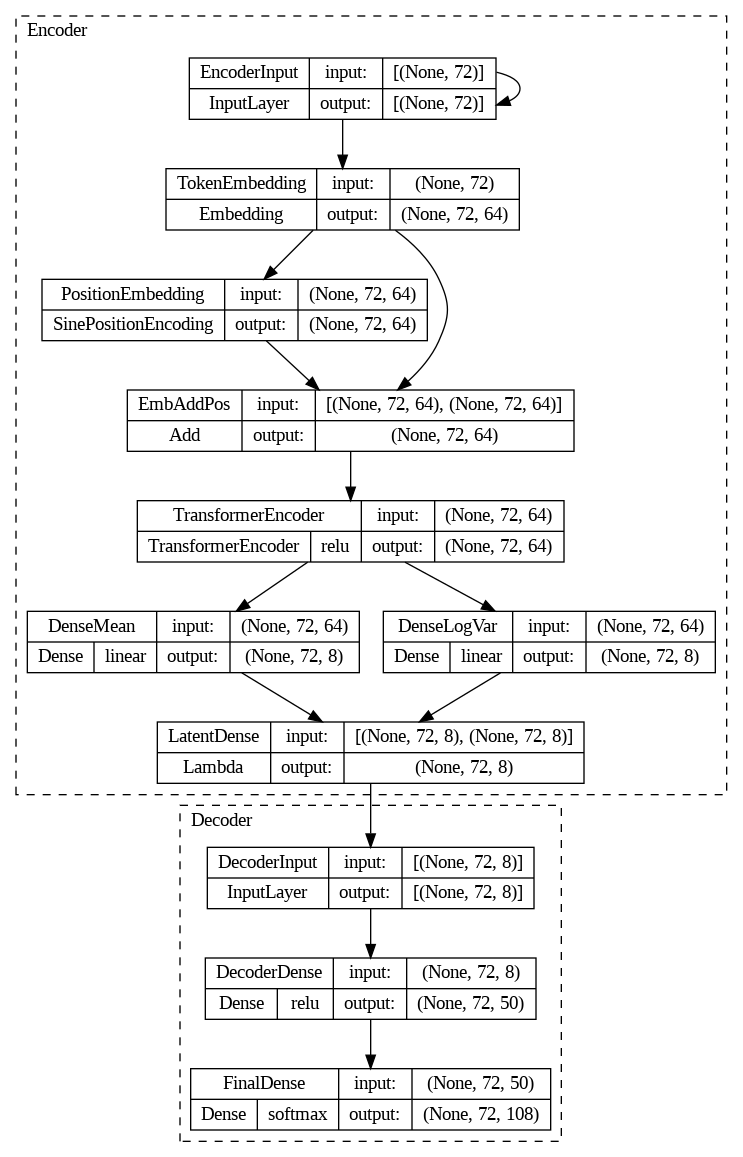

In [ ]:
#@title {vertical-output: true}
keras.utils.plot_model(
    vae,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=["Encoder", "Decoder"],
    show_layer_activations=True,
)

### E.2. Training and Testing

#### Callbacks
Checkpoint weight saving and Early Stop.

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = '/content/drive/MyDrive/Colab Notebooks/Models/weightsCheckpoint.hdf5', #weights.{epoch:02d}-{val_loss:.2f}.hdf5'
    save_weights_only = True,
    monitor = 'val_loss', #'val_sparse_categorical_accuracy'
    mode = 'min',
    save_best_only = True,
    # verbose = True,
)

early_stop = keras.callbacks.EarlyStopping(
  monitor = 'val_loss',
  mode = 'min',
  patience = 4,
  min_delta = 0.0001,
  verbose = True,
)

#### Fit

In [ ]:
EPOCHS = 20
BATCH_SIZE = 32    # Change `BATCH_SIZE` (ex. 100 or 128) to something large when using a GPU. When using CPU use around 32. :)

for i in range(len(vae.weights)):
    vae.weights[i]._handle_name = vae.weights[i].name + "_" + str(i)

history = vae.fit(
    x = train_set,
    y = train_set,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    shuffle = True,
    validation_data = [validation_set, validation_set],
    callbacks = [
        checkpoint,
        early_stop,
    ],
)

Epoch 1/20
2500/2500 [==============================] - 256s 102ms/step - loss: 0.2083 - sparse_categorical_accuracy: 0.9862 - val_loss: 0.1212 - val_sparse_categorical_accuracy: 0.9940
Epoch 2/20
2500/2500 [==============================] - 251s 100ms/step - loss: 0.1068 - sparse_categorical_accuracy: 0.9944 - val_loss: 0.0974 - val_sparse_categorical_accuracy: 0.9951
Epoch 3/20
2500/2500 [==============================] - 251s 100ms/step - loss: 0.0966 - sparse_categorical_accuracy: 0.9947 - val_loss: 0.0953 - val_sparse_categorical_accuracy: 0.9956
Epoch 4/20
2500/2500 [==============================] - 253s 101ms/step - loss: 0.0929 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.0922 - val_sparse_categorical_accuracy: 0.9951
Epoch 5/20
2500/2500 [==============================] - 252s 101ms/step - loss: 0.0915 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.0888 - val_sparse_categorical_accuracy: 0.9954
Epoch 6/20
2500/2500 [==============================] - 252s 101ms/ste

KeyboardInterrupt: ignored

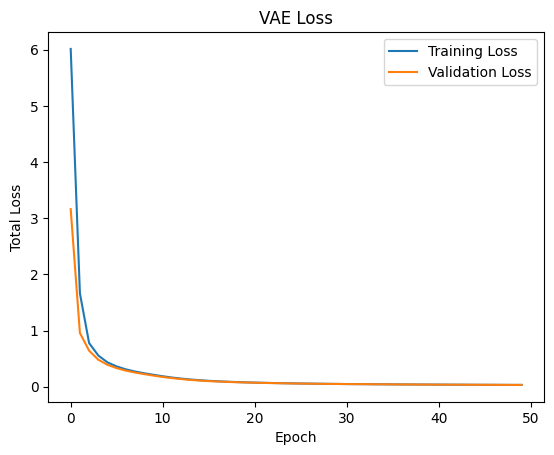

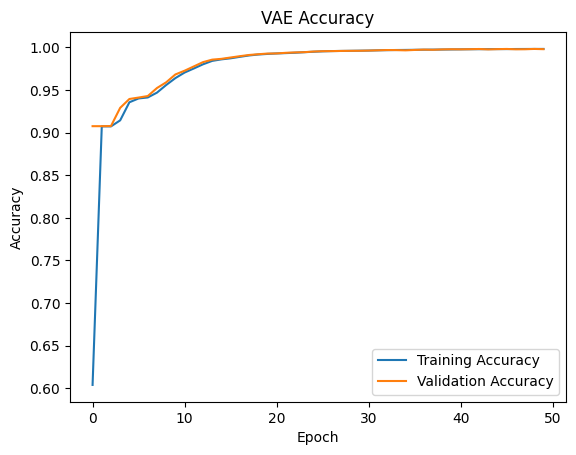

In [ ]:
#@title {vertical-output: true}
# Total Loss Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VAE Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

# Accuracy Plot
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('VAE Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

## E. Test

### Evaluate Loss and Accuracy on Test Set

In [27]:
vae.evaluate(
    x = test_set,
    y = test_set
)

 219/1563 [===>..........................] - ETA: 48s - loss: 0.0879 - sparse_categorical_accuracy: 0.9951

KeyboardInterrupt: ignored

### Position Comparison

In [ ]:
#@title {vertical-output: true}
for pos in range(1,50):
    my_list = vae.predict([test_set[5].tolist()],verbose=0)[0][pos-1]
    print("Pos",pos,":",test_set[5][pos-1]," vs. ",np.argmax(my_list))

Pos 1 : 61  vs.  61
Pos 2 : 74  vs.  74
Pos 3 : 61  vs.  61
Pos 4 : 32  vs.  32
Pos 5 : 61  vs.  61
Pos 6 : 32  vs.  32
Pos 7 : 61  vs.  61
Pos 8 : 32  vs.  32
Pos 9 : 82  vs.  82
Pos 10 : 30  vs.  30
Pos 11 : 61  vs.  61
Pos 12 : 67  vs.  67
Pos 13 : 53  vs.  53
Pos 14 : 61  vs.  61
Pos 15 : 61  vs.  61
Pos 16 : 55  vs.  55
Pos 17 : 53  vs.  53
Pos 18 : 61  vs.  61
Pos 19 : 61  vs.  61
Pos 20 : 61  vs.  61
Pos 21 : 32  vs.  32
Pos 22 : 61  vs.  61
Pos 23 : 32  vs.  32
Pos 24 : 53  vs.  53
Pos 25 : 30  vs.  30
Pos 26 : 61  vs.  61
Pos 27 : 30  vs.  30
Pos 28 : 61  vs.  61
Pos 29 : 40  vs.  40
Pos 30 : 73  vs.  73
Pos 31 : 74  vs.  74
Pos 32 : 82  vs.  82
Pos 33 : 54  vs.  54
Pos 34 : 0  vs.  0
Pos 35 : 0  vs.  0
Pos 36 : 0  vs.  0
Pos 37 : 0  vs.  0
Pos 38 : 0  vs.  0
Pos 39 : 0  vs.  0
Pos 40 : 0  vs.  0
Pos 41 : 0  vs.  0
Pos 42 : 0  vs.  0
Pos 43 : 0  vs.  0
Pos 44 : 0  vs.  0
Pos 45 : 0  vs.  0
Pos 46 : 0  vs.  0
Pos 47 : 0  vs.  0
Pos 48 : 0  vs.  0
Pos 49 : 0  vs.  0


### Generate Latent Vector and Reconstruct Figure

Latent Vector:
 [[[ 8.92302319e-02  1.30545706e-01 -2.23160386e-01 -1.67325616e-01
    1.14056915e-01 -4.65269029e-01  1.19229183e-01 -9.16913301e-02]
  [-4.97289747e-03  7.44275004e-02  1.44900918e-01  4.30913150e-01
   -4.80713010e-01 -1.33853406e-02  5.27182966e-02 -1.27741635e-01]
  [ 2.87093967e-01  1.79629594e-01 -9.53622982e-02  1.77033260e-01
   -2.31107343e-02 -1.07871868e-01 -5.11272401e-02 -2.15913188e-02]
  [ 1.25080675e-01  1.67055130e-01 -2.53261700e-02 -1.47121057e-01
    1.58280343e-01 -2.64060229e-01 -1.34280190e-01  3.88586149e-03]
  [-9.49018300e-02 -4.88044411e-01  1.19025521e-02 -1.22134797e-01
   -3.01410351e-02  1.04342259e-01  1.08249463e-01 -1.01126358e-02]
  [-3.61456722e-02 -2.07888290e-01 -1.05932020e-01 -2.95098484e-01
    7.43828341e-02 -2.83697665e-01  7.73850083e-02 -6.08915128e-02]
  [-1.98320895e-02  2.55963840e-02  6.24857068e-01 -6.21990822e-02
   -1.14376202e-01 -3.32457960e-01  1.51314318e-01 -1.76224232e-01]
  [-1.34521350e-03 -1.66321211e-02 -1.6

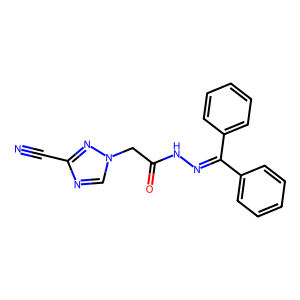

Re.png


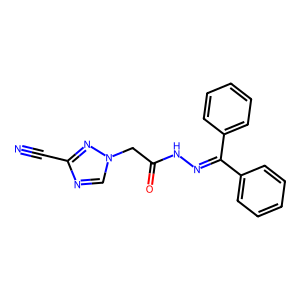

In [ ]:
#@title {vertical-output: true}
extraInfo = False
dataMode = 2 # 1 for train-data ONLY, 2 for ALL data, 3 for custom

if dataMode == 1:
    test = data_SMILES.iloc[random.randint(50_000,60_000),0]
elif dataMode == 2:
    test = data_SMILES.iloc[random.randint(1, len(data_SMILES)-1),0]
elif dataMode == 3:
    test = 'CCc(c1)ccc2[n+]1ccc3c2[nH]c4c3cccc4CCc1c[n+]2ccc3c4ccccc4[nH]c3c2cc1'
test_i = test
if extraInfo: print("SMILES:", test)
test = sf.encoder(test)
if extraInfo: print("SELFIES", test)
test = sf.selfies_to_encoding(
        selfies = test,
        vocab_stoi = symbol_to_idx,
        pad_to_len = max_length,
        enc_type = "label"
    )
if extraInfo: print("SELFIES Encoding:", test)
latent_vector = encoder.predict(np.expand_dims(test,0),verbose=0)[2]
print("Latent Vector:\n", latent_vector, "\n")
test = vae.predict(np.expand_dims(test,0),verbose=0)[0]
if extraInfo: print("Recreated Input:", test)
if extraInfo: print("Recreated Input from Latent Vector:", decoder.predict([latent_vector.tolist()]))
test = np.argmax(test, axis=1)
test = sf.encoding_to_selfies(
    encoding = test,
    vocab_itos = idx_to_symbol,
    enc_type = "label"
)
if extraInfo: print("Reconstructed SELFIES:", test)
test = sf.decoder(test)
print("Original SMILES:     ", test_i)
print("Reconstructed SMILES:", test)
Draw.MolToFile(Chem.MolFromSmiles(test_i),'Orig.png')
# Image('Orig.png')
Draw.MolToFile(Chem.MolFromSmiles(test),'Re.png')

listOfImageNames = ['Orig.png',
                    'Re.png']

for imageName in listOfImageNames:
    print(imageName);display(Image(filename=imageName, width=300))

### Interpolate

In [ ]:
def smiles_to_encoding_test(x):
    x = sf.encoder(x)
    x = sf.selfies_to_encoding(selfies=x, vocab_stoi=symbol_to_idx, pad_to_len=max_length, enc_type="label")
    return np.expand_dims(x,0)

def encoding_to_smiles_test(x):
    x = np.argmax(x, axis=1)
    x = sf.encoding_to_selfies(encoding=x, vocab_itos=idx_to_symbol, enc_type="label")
    x = sf.decoder(x)
    print(x)
    return x

CC(=O)C=CC=C(S(=O)(=O)N1CCN(C2=CC=C(C3=C4C=NC=C3)N=N2)CC1)C=C4
CC(=O)C1=CC=C(S(=O)(=O)N2CCN(C3=CC=C(C4=CC=NC=C4)N=N3)CC2)C=C1
CC(=O)C1=CC=C(S(=O)(=O)N2CCN(C3=CC=C(C4=CC=NC=C4)N=N3)CC2)C=C1
CC(=O)C1=CC=C(S(=O)(=O)N2CCN(C3=CC=C(C4=CC=NC=C4)N=N3)CC2)C=C1
CC(=O)C1=CC=C(S(=O)(=O)N2CCN(C3=CC=C(C4=CC=NC=C4)N=N3)CC2)C=C1
CC(=O)C1=CC=C(S(=O)(=O)N2CCN(C3=CC=C(C4=CC=NC=C4)N=N3)CC2)C=C1
CC(=O)C1=CC=C(S(=O)(=O)N2CCN(C3=CC=C(C4=CC=NC=C4)N=N3)CC2)C=C1
CC(=O)C=CC=C(S(=O)(=O)NCCN(C=CC=C(C)C=NC=CN=N)CC)C
CC(=O)C=CC=CS(=O)(=O)NC1CN1C=CC2=C(C)C=NC=C=NCC=C2
C1C(=O)C=CC=CC1(O)C=O
C1C(C)CCCCC1(O)C2CC2(C)CCCCCC
CC(C)CC1CCCN1C=CCCC(C)(CC)CCCC
C=C(CSC1CCCN12)NC=CC=CC2(C)NCCCCC
O=C(CSC1=[NH1+1]CCN1)NC2=CC=CC(Cl)=C2NCCCCC
O=C(CSC1=[NH1+1]CCN1)NC2=CC=CC(Cl)=C2NCCCCC
O=C(CSC1=[NH1+1]CCN1)NC2=CC=CC(Cl)=C2N3CCCCC3
O=C(CSC1=[NH1+1]CCN1)NC2=CC=CC(Cl)=C2N3CCCCC3
O=C(CSC1=[NH1+1]CCN1)NC2=CC=CC(Cl)=C2N3CCCCC3
O=C(CSC1=[NH1+1]CCN1)NC2=CC=CC(Cl)=C2N3CCCCC3
O=C(CSC1=[NH1+1]CCN1)NC2=CC=CC(Cl)=C2N3CCCCC3
O=C(CSC1=[NH1+1]CCN1)N

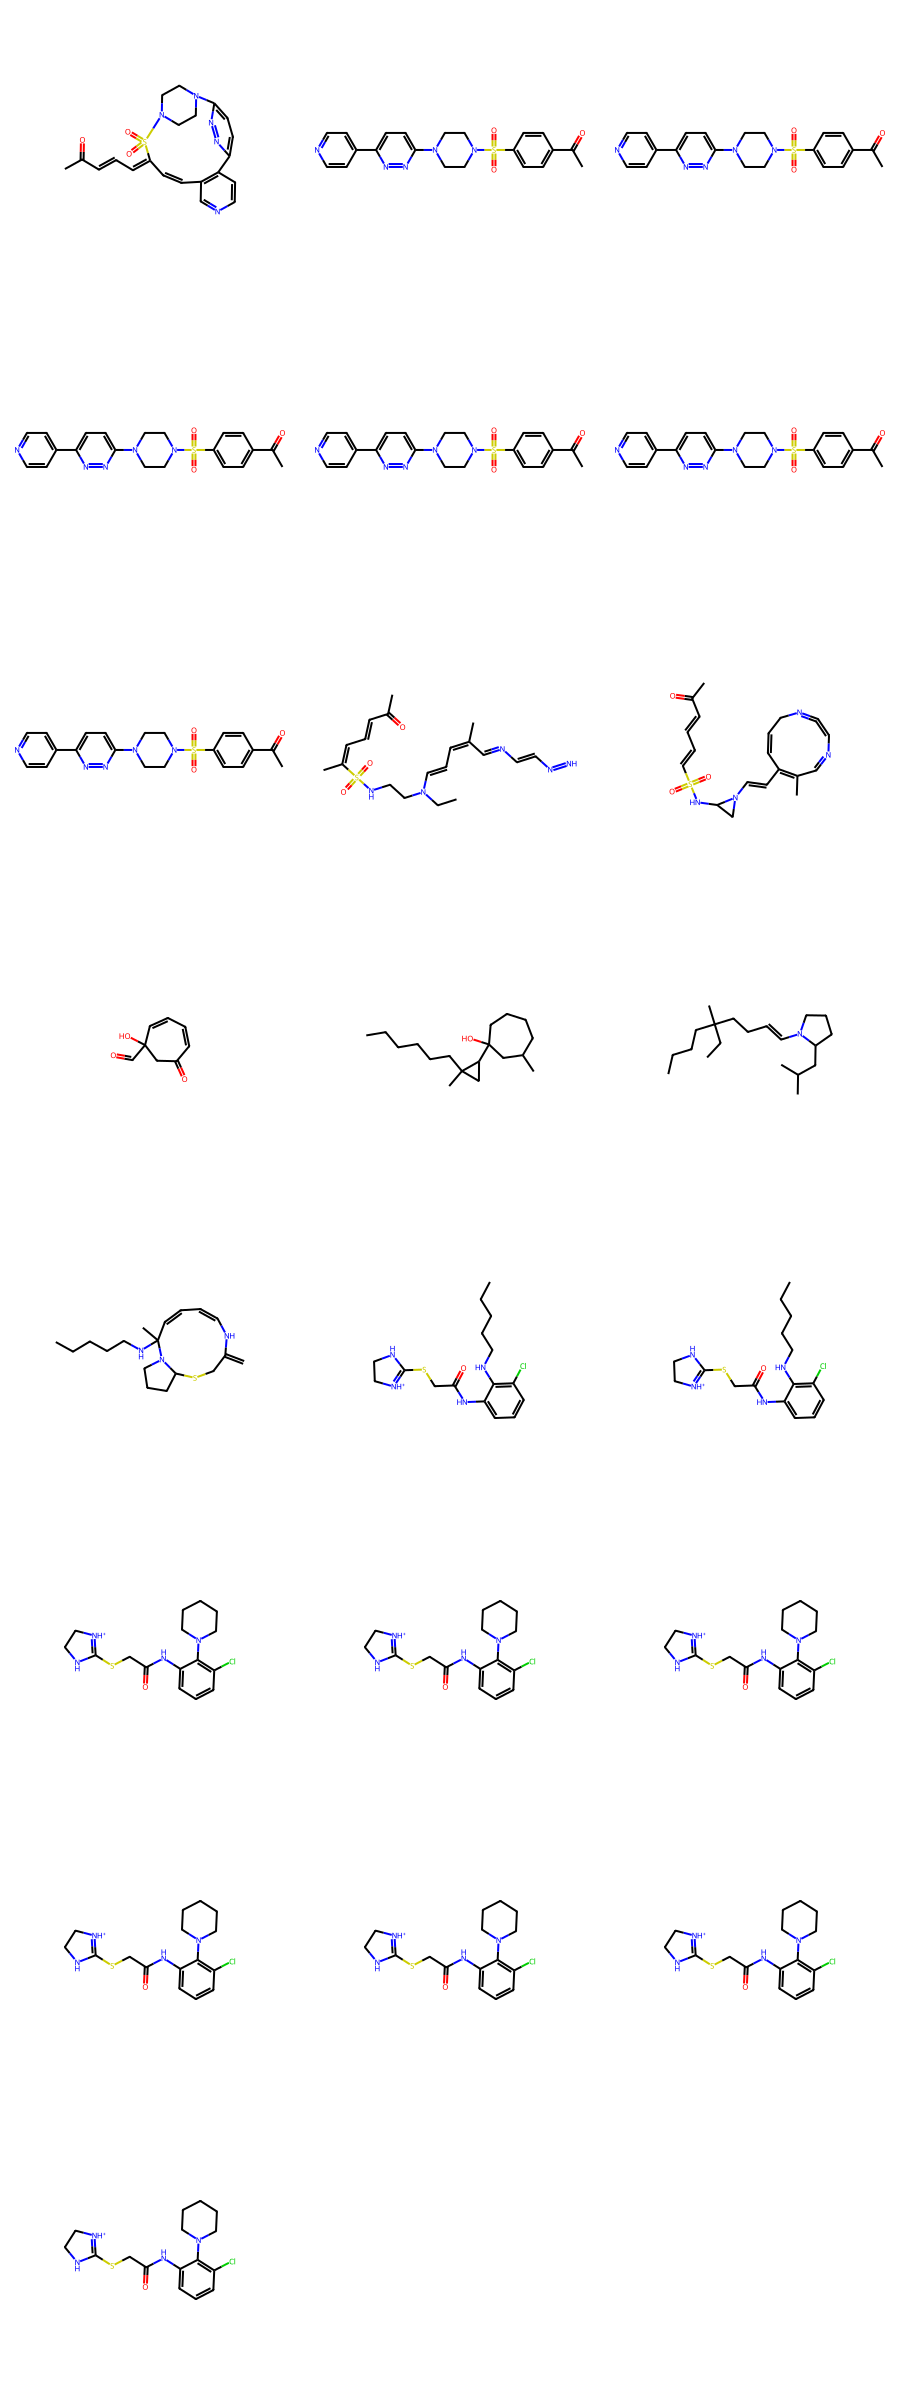

In [ ]:
#@title {vertical-output: true}
MODE = 1
num_steps = 20
COLS = 3

initial = 'O=Cc1ccc(O)c(OC)c1COc1cc(C=O)ccc1O'
final = 'O1C=C[C@H]([C@H]1O2)c3c2cc(OC)c4c3OC(=O)C5=C4CCC(=O)5'


if MODE == 1:
    initial = [test_set[random.randint(0,999)].tolist()]
    final = [test_set[random.randint(0,999)].tolist()]
elif MODE == 2:
    initial = smiles_to_encoding_test(initial)
    final = smiles_to_encoding_test(final)

z_mean1, z_log_var1, z1 = encoder.predict(initial,verbose=0)
z_mean2, z_log_var2, z2 = encoder.predict(final,verbose=0)

interpolated_latent_points = []
for i in range(num_steps):
    alpha = i / (num_steps - 1)  # Interpolation coefficient
    interpolated_latent_point = (1 - alpha) * z_mean1 + alpha * z_mean2
    interpolated_latent_points.append(interpolated_latent_point)
interpolated_data_points = decoder.predict(np.squeeze(np.array(interpolated_latent_points)),verbose=0)


# DECODING and Graphing -----------------
test_list = []
test_list.append(encoding_to_smiles_test(np.squeeze(decoder.predict(z1,verbose=0))))
for i in range(num_steps):
    test_list.append(encoding_to_smiles_test(interpolated_data_points[i]))
test_list.append(encoding_to_smiles_test(np.squeeze(decoder.predict(z2,verbose=0))))

test_list = [Chem.MolFromSmiles(smiles) for smiles in test_list]
mol_matrix = [test_list[i:i + COLS] for i in range(0, len(test_list), COLS)]
img = Draw.MolsMatrixToGridImage(mol_matrix, subImgSize=(300, 300))
display(img)

### Graphing Latent Space

Principal Component Analysis (PCA)

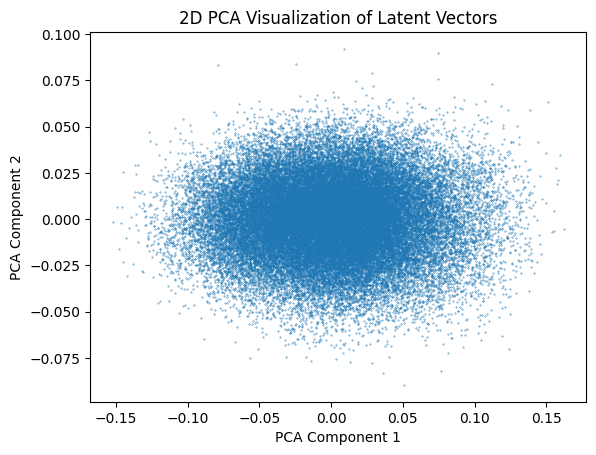

In [ ]:
#@title {vertical-output: true}
from sklearn.decomposition import PCA

latent_vectors = np.mean(encoder.predict(test_set)[2],axis=1)
# latent_vectors = encoder.predict(test_set)[2].reshape(TEST_SIZE, max_length*latent_dim)
pca = PCA(n_components=2)
latent_vectors_2d = pca.fit_transform(latent_vectors)
plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], s=0.1)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA Visualization of Latent Vectors')
plt.show()

T-distributed Stochastic Neighbor Embedding (TSNE)

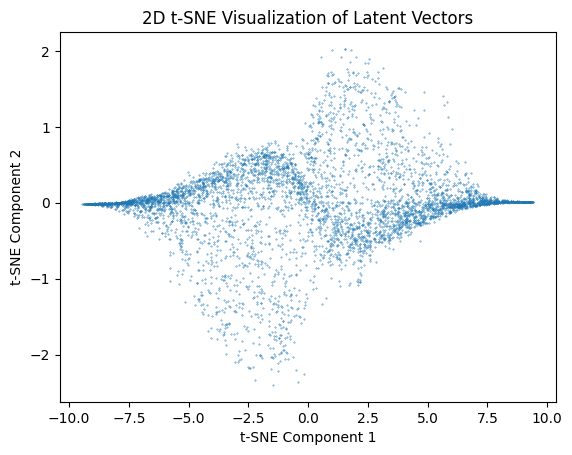

In [ ]:
#@title {vertical-output: true}
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
latent_vectors_2d_tsne = tsne.fit_transform(latent_vectors[1:5000])
plt.scatter(latent_vectors_2d_tsne[:, 0], latent_vectors_2d_tsne[:, 1], s=0.1)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('2D t-SNE Visualization of Latent Vectors')
plt.show()

### Using Learned Embedding on another Neural Network
adapted from https://keras.io/examples/generative/molecule_generation/

In [29]:
csv_path = keras.utils.get_file(
    "/content/250k_rndm_zinc_drugs_clean_3.csv",
    "https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv",
)

df = pd.read_csv("/content/250k_rndm_zinc_drugs_clean_3.csv")
df["smiles"] = df["smiles"].apply(lambda s: s.replace("\n", ""))
df.head(100)

22606589/22606589 [==============================] - 0s 0us/step


,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182
...,...,...,...,...
95,C=CCN(Cc1cccc([N+](=O)[O-])c1)C(=O)Nc1cc(OC)cc...,4.47690,0.419977,2.204004
96,Cc1cc(Cl)ccc1OCC(=O)N/N=C/c1ccccn1,2.57252,0.680288,2.075582
97,O=C1NC(=S)NC(=O)C1=CNc1ccc([N+](=O)[O-])cc1O,0.12710,0.159707,2.703933
98,Cc1c(C(=O)N2CCOCC2)oc2c1-c1nn(CC(=O)NCc3ccco3)...,1.93192,0.675385,2.845261


In [43]:
train_df = df.sample(frac=0.75, random_state=42)  # random state is a seed value
train_df.reset_index(drop=True, inplace=True)

master_smiles_set, master_prop_set = [], []
for idx in range(10000):
    master_smiles_set.append(train_df.loc[idx]["smiles"])
    master_prop_set.append(train_df.loc[idx]["logP"])

master_selfies_set = [sf.encoder(s) for s in master_smiles_set]
master_encoding_set = [sf.selfies_to_encoding(
                                selfies = s,
                                vocab_stoi = symbol_to_idx,
                                pad_to_len = max_length,
                                enc_type = "label"
                            ) for s in master_selfies_set]
master_encoding_set = np.array(master_encoding_set)
master_prop_set = np.array(master_prop_set)


In [44]:
#@title {vertical-output: true}
testNN_input = Input((max_length,), dtype='int32', name='TestInput')
x = encoder(testNN_input)[2]; encoder.trainable = False
# x = Embedding(
#     input_dim=vocab_size,
#     output_dim=embed_dim,
#     input_length=max_length,
#     trainable=True,
#     mask_zero=True,)(testNN_input)
x = Dense(64, activation='tanh', name="DenseExpand")(x)
x = Dense(vocab_size, activation='tanh', name="DenseExpand2")(x)
x = Dense(vocab_size, activation='tanh', name="DenseExpand3")(x)
x = GlobalAveragePooling1D(name="GlobalAveragePooling1D")(x)
# x = Flatten(name="TestFlatten")(x)
x = Dense(vocab_size/2, activation='tanh', name="DenseShrink")(x)
x = Dense(vocab_size/4, activation='tanh', name="DenseShrink2")(x)
x = Dense(vocab_size/4, activation='relu', name="DenseShrink3")(x)
testNN_output = Dense(1, activation='linear')(x)

testNN = Model(testNN_input, testNN_output, name="TestNeuralNetwork")
testNN.compile(optimizer = "adam", loss = 'mse')
testNN.summary()

Model: "TestNeuralNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 TestInput (InputLayer)      [(None, 72)]              0         
                                                                 
 ChemVATSEncoder (Functiona  [(None, 72, 8),           28004     
 l)                           (None, 72, 8),                     
                              (None, 72, 8)]                     
                                                                 
 DenseExpand (Dense)         (None, 72, 64)            576       
                                                                 
 DenseExpand2 (Dense)        (None, 72, 108)           7020      
                                                                 
 DenseExpand3 (Dense)        (None, 72, 108)           11772     
                                                                 
 GlobalAveragePooling1D (Gl  (None, 108)         

In [52]:
test_history = testNN.fit(
    x = master_encoding_set,
    y = master_prop_set,
    epochs = 30,
    batch_size = 32,
    shuffle = True,
    validation_split = 0.1,
)

Epoch 1/30
282/282 [==============================] - 14s 50ms/step - loss: 1.0854 - val_loss: 1.0186
Epoch 2/30
282/282 [==============================] - 9s 30ms/step - loss: 1.0547 - val_loss: 0.9813
Epoch 3/30
282/282 [==============================] - 11s 40ms/step - loss: 1.0730 - val_loss: 1.0235
Epoch 4/30
282/282 [==============================] - 10s 37ms/step - loss: 1.0819 - val_loss: 1.0177
Epoch 5/30
282/282 [==============================] - 9s 31ms/step - loss: 1.0657 - val_loss: 1.2323
Epoch 6/30
282/282 [==============================] - 11s 38ms/step - loss: 1.0703 - val_loss: 0.9501
Epoch 7/30
282/282 [==============================] - 9s 33ms/step - loss: 1.0119 - val_loss: 1.0405
Epoch 8/30
282/282 [==============================] - 10s 35ms/step - loss: 1.0477 - val_loss: 0.9821
Epoch 9/30
282/282 [==============================] - 11s 38ms/step - loss: 1.0584 - val_loss: 1.0646
Epoch 10/30
282/282 [==============================] - 8s 30ms/step - loss: 1.0265 - 

In [ ]:
test = random.randint(0,10_000)
print(master_smiles_set[test])
print("Actual:     ", master_prop_set[test], "\nPrediction: ", testNN.predict(np.expand_dims(master_encoding_set[test],0), verbose=0)[0,0])

C[C@H]([NH3+])Cc1ccnc(-c2ncc(Cl)cc2Cl)n1
Actual:      0.941864449174 
Prediction:  0.7752951


313/313 [==============================] - 9s 29ms/step


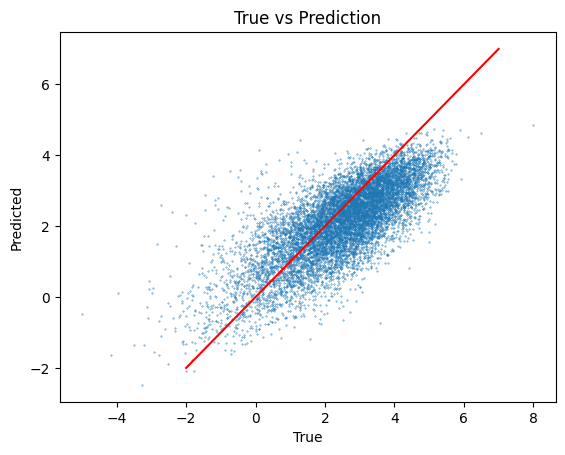

In [53]:
#@title {vertical-output: true}
test = testNN.predict(master_encoding_set)
plt.scatter(master_prop_set, test, s=0.1)
plt.plot(np.array([-2,7]), np.array([-2,7]), label='y = x', color='red')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('True vs Prediction')
plt.show()

## F. Saving and Loading Model or Weights

Save Model and Custom Layers

In [24]:
SAVE_LOAD = "LOAD"
CHECKPOINT_LOAD = False
# WEIGHTS_MODEL =

if SAVE_LOAD == "SAVE":
    # vae.save('/content/drive/MyDrive/Colab Notebooks/Models/ChemVATS.keras')
    vae.save_weights("/content/drive/MyDrive/Colab Notebooks/Models/ChemVATS_weights.h5")
    print("SAVE succesful!")
elif SAVE_LOAD == "LOAD":
    # vae = keras.models.load_model(
    #     '/content/drive/MyDrive/Colab Notebooks/Models/ChemVATS.keras',
    #     custom_objects={
    #         # "TransformerPackage": TransformerBlock,
    #         # "TokenAndPositionPackage": TokenAndPositionEmbedding
    #     },
    #     safe_mode=False
    # )
    if CHECKPOINT_LOAD:
        vae.load_weights('/content/drive/MyDrive/Colab Notebooks/Models/weightsCheckpoint.hdf5')
    else:
        vae.load_weights('/content/drive/MyDrive/Colab Notebooks/Models/ChemVATS_weights.h5')
    print("LOAD succesful!")

LOAD succesful!


# OTHERS

In [ ]:
# Avoids scroll-in-the-scroll in the entire Notebook
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

In [ ]:
model = Sequential([Embedding(input_dim=5+1, output_dim=2, input_length=5), Flatten()])
model.compile('rmsprop', 'mse')
model.predict(tf.constant([[1,2,3,4,5],[5,5,5,5,5]]))

1/1 [==============================] - 0s 177ms/step


array([[-0.00806739, -0.02008803, -0.00773904, -0.00908155,  0.02701206,
        -0.03173574,  0.01688141,  0.02214426, -0.02796904,  0.00033376],
       [-0.02796904,  0.00033376, -0.02796904,  0.00033376, -0.02796904,
         0.00033376, -0.02796904,  0.00033376, -0.02796904,  0.00033376]],
      dtype=float32)